# 1. 필요한 Module 추가 및 기본 세팅

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 1.1. Colab의 경우 tensorflow version이 2.5.0이라서 논문에서 사용한 1.15.2 version으로 바꿔주기 위해 삭제

In [ ]:
!pip uninstall tensorflow

Uninstalling tensorflow-2.5.0:
  Would remove:
    /usr/local/bin/estimator_ckpt_converter
    /usr/local/bin/import_pb_to_tensorboard
    /usr/local/bin/saved_model_cli
    /usr/local/bin/tensorboard
    /usr/local/bin/tf_upgrade_v2
    /usr/local/bin/tflite_convert
    /usr/local/bin/toco
    /usr/local/bin/toco_from_protos
    /usr/local/lib/python3.7/dist-packages/tensorflow-2.5.0.dist-info/*
    /usr/local/lib/python3.7/dist-packages/tensorflow/*
Proceed (y/n)? y
y
  Successfully uninstalled tensorflow-2.5.0


## 1.2. 논문에서 사용한 module 설치(requirements.txt)  
### __반드시 이 부분 실행 후 Restart runtime 클릭해야 함!__

In [ ]:
!pip install -r '/content/drive/MyDrive/Colab Notebooks/Timeseries/Team_project/VAE-LSTM-for-anomaly-detection/requirements.txt'

     |████████████████████████████████| 17.3MB 192kB/s 
     |████████████████████████████████| 10.4MB 48.1MB/s 
     |████████████████████████████████| 1.0MB 51.8MB/s 
     |████████████████████████████████| 32.6MB 86kB/s 
     |████████████████████████████████| 411.0MB 39kB/s 
     |████████████████████████████████| 983kB 45.9MB/s 
     |████████████████████████████████| 71kB 11.0MB/s 
     |████████████████████████████████| 3.8MB 39.6MB/s 
     |████████████████████████████████| 51kB 8.4MB/s 
     |████████████████████████████████| 512kB 46.9MB/s 
  Created wheel for GPy: filename=GPy-1.9.9-cp37-cp37m-linux_x86_64.whl size=2627019 sha256=945e98339e23b7890df378150bea67177196d139a4d993e3430cbb1b3018c8b6
  Stored in directory: /root/.cache/pip/wheels/5d/36/66/2b58860c84c9f2b51615da66bfd6feeddbc4e04d887ff96dfa
  Created wheel for munch: filename=munch-2.3.2-py2.py3-none-any.whl size=6630 sha256=4a291868fdfea5a10e08cb6385b7f81a723e07460ee05a052698c63fbe49763a
  Stored in directory: /root

In [ ]:
import tensorflow as tf
print(tf.__version__)

1.15.2


In [ ]:
import warnings

def fxn():
    warnings.warn("deprecated", DeprecationWarning)

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    fxn()

In [ ]:
import tensorflow as tf
import tensorflow_probability as tfp
import numpy as np
import matplotlib.pylab as plt
from matplotlib.pyplot import plot, ion, show, savefig, cla, figure
import random
import time

# 논문에서 만든 module 사용하기 위해 추가
import sys
sys.path.append('/content/drive/MyDrive/Colab Notebooks/Timeseries/Team_project/VAE-LSTM-for-anomaly-detection/codes')

import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="0"

from data_loader import DataGenerator
from models import VAEmodel, lstmKerasModel
from trainers import vaeTrainer
from utils import process_config, create_dirs, get_args

In [ ]:
from tensorflow.python.client import device_lib

def get_available_gpus():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos if x.device_type == 'GPU']

print(get_available_gpus())

['/device:GPU:0']


# 2. 모델 불러오기

## 2.1. VAE 모델 불러오기

Device mapping:
/job:localhost/replica:0/task:0/device:XLA_CPU:0 -> device: XLA_CPU device
/job:localhost/replica:0/task:0/device:XLA_GPU:0 -> device: XLA_GPU device
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5

[Data loader 1]
[Data loader 2]
[Data loader 3]
[Data loader 4]
[Data loader 6]



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Instructions for updating:
Use `for ... in dataset:` to iterate over a dataset. If using `tf.estimator`, return the `Dataset` object directly from your input function. As a last resort, you can use `tf.compat.v1.data.make_initializable_iterator(dataset)`.
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for 

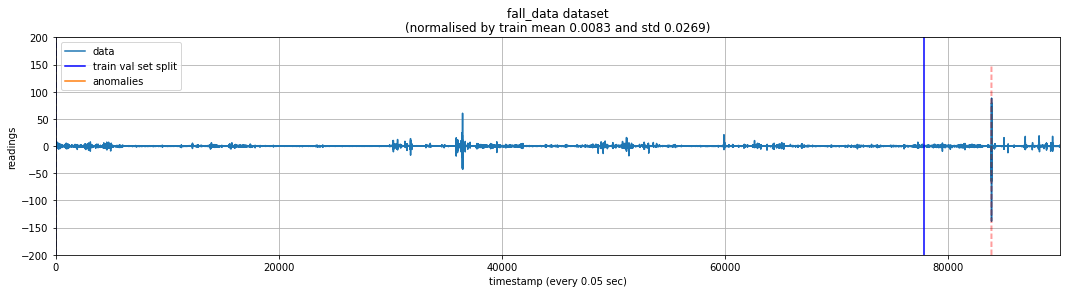

In [ ]:
# load VAE model
config = process_config('/content/drive/MyDrive/Colab Notebooks/Timeseries/Team_project/VAE-LSTM-for-anomaly-detection/codes/NAB_config.json')
# create the experiments dirs
create_dirs([config['result_dir'], config['checkpoint_dir']])
# create tensorflow session
sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))
# create your data generator
data = DataGenerator(config)
# create a CNN model
model_vae = VAEmodel(config)
trainer_vae = vaeTrainer(sess, model_vae, data, config)
model_vae.load(sess)

In [ ]:
config = process_config('/content/drive/MyDrive/Colab Notebooks/Timeseries/Team_project/VAE-LSTM-for-anomaly-detection/codes/NAB_config.json')
config

{'TRAIN_LSTM': 1,
 'TRAIN_VAE': 1,
 'TRAIN_sigma': 1,
 'batch_size': 64,
 'batch_size_lstm': 64,
 'checkpoint_dir': '/content/drive/MyDrive/Colab Notebooks/Timeseries/Team_project/VAE-LSTM-for-anomaly-detection/experiments/local-results/NAB/fall_data/batch-64/NAB-fall_data-24-6-10-trainSigma/checkpoint/',
 'checkpoint_dir_lstm': '/content/drive/MyDrive/Colab Notebooks/Timeseries/Team_project/VAE-LSTM-for-anomaly-detection/experiments/local-results/NAB/fall_data/batch-64/NAB-fall_data-24-6-10-trainSigma/checkpoint/lstm/',
 'code_size': 10,
 'dataset': 'fall_data',
 'exp_name': 'NAB',
 'l_seq': 6,
 'l_win': 24,
 'learning_rate_lstm': 0.0002,
 'learning_rate_vae': 0.0004,
 'load_dir': '/content/drive/MyDrive/Colab Notebooks/Timeseries/Team_project/VAE-LSTM-for-anomaly-detection/experiments/local-results/NAB/fall_data/batch-64',
 'load_model': 1,
 'n_channel': 1,
 'num_epochs_lstm': 20,
 'num_epochs_vae': 20,
 'num_hidden_units': 512,
 'num_hidden_units_lstm': 64,
 'one_image': 0,
 'result

## 2.2. LSTM 모델 불러오기

In [ ]:
# load LSTM model
lstm_model = lstmKerasModel(data)
lstm_nn_model = lstm_model.create_lstm_model(config)
lstm_nn_model.summary()   # Display the model's architecture

# checkpoint path
checkpoint_path = config['checkpoint_dir_lstm'] + "cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)
# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)
# load weights if possible
lstm_model.load_model(lstm_nn_model, config, checkpoint_path)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 5, 10)]           0         
_________________________________________________________________
lstm (LSTM)                  (None, 5, 64)             19200     
_________________________________________________________________
lstm_1 (LSTM)                (None, 5, 64)             33024     
_________________________________________________________________
lstm_2 (LSTM)                (None, 5, 10)             3000      
Total params: 55,224
Trainable params: 55,224
Non-trainable params: 0
_________________________________________________________________
/content/drive/MyDrive/Colab Notebooks/Timeseries/Team_project/VAE-LSTM-for-anomaly-detection/experiments/local-results/NAB/fall_data/batch-64/NAB-fall_data-24-6-10-trainSigm

# 3. 데이터 전처리

## 3.1. 검증 및 테스트 데이터 처리

### 3.1.1. 시계열 데이터를 Sequence size와 Window size로 잘라주는 함수

In [ ]:
# slice into rolling windows and rolling sequences
def slice_rolling_windows_and_sequences(config, time_seq):
    n_sample = len(time_seq)
    print("The given sequence has {} samples".format(n_sample))
    n_vae_win = n_sample - config['l_win'] + 1
    rolling_windows = np.zeros((n_vae_win, config['l_win']))
    for i in range(n_vae_win):
        print(i,'/',n_vae_win)
        rolling_windows[i] = time_seq[i:i + config['l_win']]
        sample_m = np.mean(rolling_windows, axis=1)
        sample_std = np.std(rolling_windows, axis=1)

        n_lstm_seq = n_sample - config['l_seq']*config['l_win']+1
        lstm_seq = np.zeros((n_lstm_seq, config['l_seq'], config['l_win']))
    for i in range(n_lstm_seq):
        print(i,'/',n_lstm_seq)
        cur_seq = time_seq[i:i+config['l_seq']*config['l_win']]
        for j in range(config['l_seq']):
            lstm_seq[i,j] = cur_seq[config['l_win']*j:config['l_win']*(j+1)]
    
    return rolling_windows, lstm_seq, sample_m, sample_std

### 3.1.2. 검증 데이터 Sequence로 변경 (N, l_seq, l_win)



In [ ]:
# 검증 데이터 sequence로 변경

# load normalised time series
save_dir = '/content/drive/MyDrive/Colab Notebooks/Timeseries/Team_project/VAE-LSTM-for-anomaly-detection/datasets/NAB-known-anomaly/'
dataset = config['dataset']
filename = '{}.npz'.format(dataset)
result = dict(np.load(save_dir+filename, allow_pickle=True))

'''
val_windows, val_seq, val_sample_m, val_sample_std = slice_rolling_windows_and_sequences(config, result['test'])
val_windows = np.expand_dims(val_windows, -1)
val_seq = np.expand_dims(val_seq, -1)
print(val_windows.shape)
print(val_seq.shape)

np.save('/content/drive/MyDrive/Colab Notebooks/Timeseries/Team_project/VAE-LSTM-for-anomaly-detection/datasets/data_numpy/val_seq.npy', val_seq)
'''

val_seq = np.load('/content/drive/MyDrive/Colab Notebooks/Timeseries/Team_project/VAE-LSTM-for-anomaly-detection/datasets/data_numpy/val_seq.npy')

In [ ]:
test_seq.shape

(12022, 6, 24, 1)

### 3.1.3. 테스트 데이터 Sequence로 변경 (N, l_seq, l_win)

In [ ]:
# 테스트 데이터 sequence로 변경

# load normalised time series
save_dir = '/content/drive/MyDrive/Colab Notebooks/Timeseries/Team_project/VAE-LSTM-for-anomaly-detection/datasets/NAB-known-anomaly/'
test_dataset = 'test_fall_data'
test_filename = '{}.npz'.format(test_dataset)
test_result = dict(np.load(save_dir+test_filename, allow_pickle=True))

'''
test_windows, test_seq, test_sample_m, test_sample_std = slice_rolling_windows_and_sequences(config, test_result['test'])
test_windows = np.expand_dims(test_windows, -1)
test_seq = np.expand_dims(test_seq, -1)
print(test_windows.shape)
print(test_seq.shape)

np.save('/content/drive/MyDrive/Colab Notebooks/Timeseries/Team_project/VAE-LSTM-for-anomaly-detection/datasets/data_numpy/test_seq.npy', test_seq)
'''

test_seq = np.load('/content/drive/MyDrive/Colab Notebooks/Timeseries/Team_project/VAE-LSTM-for-anomaly-detection/datasets/data_numpy/test_seq.npy')

# 4. Reconstruction error 계산  
- VAE로 Embedding 된 값(vae_embedding)을 LSTM의 input(idx: 0 ~ 4)으로 받아서 다음 seq(idx: 1 ~ 5)를 예측(lstm_embedding)
- lstm_embedding를 VAE decoder로 recons_win_lstm 생성  
- 실제 데이터(val_seq)와 recons_win_lstm의 차이(lstm_recons_error)가 threshold보다 클 경우 비정상 데이터라고 판단




## 4.1. Reconstruction error 계산 함수

In [ ]:
def evaluate_lstm_anomaly_metric_for_a_seq(val_seq):
    feed_dict = {model_vae.original_signal: val_seq,
                 model_vae.is_code_input: False,
                 model_vae.code_input: np.zeros((1, config['code_size']))}
    vae_embedding = np.squeeze(sess.run(model_vae.code_mean, feed_dict=feed_dict))
    #print(vae_embedding.shape)
    lstm_embedding = np.squeeze(lstm_nn_model.predict(np.expand_dims(vae_embedding[:config['l_seq']-1], 0), batch_size=1))
    lstm_embedding_error = np.sum(np.square(vae_embedding[1:] - lstm_embedding))
    
    # LSTM prediction error
    feed_dict_lstm = {model_vae.original_signal: np.zeros((config['l_seq'] - 1, config['l_win'], 1)),
                      model_vae.is_code_input: True,
                      model_vae.code_input: lstm_embedding}
    recons_win_lstm = np.squeeze(sess.run(model_vae.decoded, feed_dict=feed_dict_lstm))
    lstm_recons_error = np.sum(np.square(recons_win_lstm - np.squeeze(val_seq[1:])))
    return lstm_recons_error, lstm_embedding_error

## 4.2. 검증 및 테스트 데이터 Reconstruction error 구함

### 4.2.1. 검증 데이터 Reconstruction error 구함

In [ ]:
# Evaluate the anomaly metrics on the val windows and sequences
n_val_lstm = val_seq.shape[0]
'''
val_lstm_recons_error, val_lstm_embedding_error = np.zeros(n_val_lstm), np.zeros(n_val_lstm)
for i in range(n_val_lstm):
    print(f'i={i}')
    val_lstm_recons_error[i], val_lstm_embedding_error[i] = evaluate_lstm_anomaly_metric_for_a_seq(val_seq[i])
print("All windows' reconstruction error is computed.")
print("The total number of windows is {}".format(len(val_lstm_recons_error)))

np.save('/content/drive/MyDrive/Colab Notebooks/Timeseries/Team_project/VAE-LSTM-for-anomaly-detection/experiments/val_lstm_recons_error', val_lstm_recons_error)
'''
val_lstm_recons_error = np.load('/content/drive/MyDrive/Colab Notebooks/Timeseries/Team_project/VAE-LSTM-for-anomaly-detection/experiments/val_lstm_recons_error.npy')

### 4.2.2. 테스트 데이터 Reconstruction error 구함

In [ ]:
# Evaluate the anomaly metrics on the test windows and sequences
n_test_lstm = test_seq.shape[0]
'''
test_lstm_recons_error, test_lstm_embedding_error = np.zeros(n_test_lstm), np.zeros(n_test_lstm)
for i in range(n_test_lstm):
    print(f'i={i}')
    test_lstm_recons_error[i], test_lstm_embedding_error[i] = evaluate_lstm_anomaly_metric_for_a_seq(test_seq[i])
print("All windows' reconstruction error is computed.")
print("The total number of windows is {}".format(len(test_lstm_recons_error)))

np.save('/content/drive/MyDrive/Colab Notebooks/Timeseries/Team_project/VAE-LSTM-for-anomaly-detection/experiments/test_lstm_recons_error', test_lstm_recons_error)
'''
test_lstm_recons_error = np.load('/content/drive/MyDrive/Colab Notebooks/Timeseries/Team_project/VAE-LSTM-for-anomaly-detection/experiments/test_lstm_recons_error.npy')

# 5. Sequence 데이터에 대한 anomaly labeling

In [ ]:
idx_anomaly_val = result['idx_anomaly_test']
anomaly_index_lstm = [] 
cnt = 0
anomaly_range = []
val_labels_lstm = np.zeros(n_val_lstm)

for i, idx_anomaly in enumerate(idx_anomaly_val[:len(idx_anomaly_val)-1]):
    target = idx_anomaly+1
    if target != idx_anomaly_val[i+1]:
        anomaly_range.append(idx_anomaly_val[cnt:i+1])
        cnt = i
    if i==len(idx_anomaly_val)-2:
        anomaly_range.append(idx_anomaly_val[cnt+1:])

for anomaly in anomaly_range:
    left = anomaly[-1]-(config['l_win']*config['l_seq'])
    right = anomaly[0]
    val_labels_lstm[left:right] = 1

for j, val_label in enumerate(val_labels_lstm):
    if val_label == 1:
        anomaly_index_lstm.append(np.arange(j,j+config['l_win']*config['l_seq']+1))

np.save('/content/drive/MyDrive/Colab Notebooks/Timeseries/Team_project/VAE-LSTM-for-anomaly-detection/datasets/data_numpy/val_labels', val_labels_lstm)
val_labels_lstm = np.load('/content/drive/MyDrive/Colab Notebooks/Timeseries/Team_project/VAE-LSTM-for-anomaly-detection/datasets/data_numpy/val_labels.npy')

In [ ]:
idx_anomaly_test = test_result['idx_anomaly_test']
test_anomaly_index_lstm = [] 
cnt = 0
test_anomaly_range = []
test_labels_lstm = np.zeros(n_test_lstm)

for i, idx_anomaly in enumerate(idx_anomaly_test[:len(idx_anomaly_test)-1]):
    target = idx_anomaly+1
    if target != idx_anomaly_test[i+1]:
        test_anomaly_range.append(idx_anomaly_test[cnt:i+1])
        cnt = i
    if i==len(idx_anomaly_test)-2:
        test_anomaly_range.append(idx_anomaly_test[cnt+1:])

for anomaly in test_anomaly_range:
    left = anomaly[-1]-(config['l_win']*config['l_seq'])
    right = anomaly[0]
    test_labels_lstm[left:right] = 1

for j, test_label in enumerate(test_labels_lstm):
    if test_label == 1:
        test_anomaly_index_lstm.append(np.arange(j,j+config['l_win']*config['l_seq']+1))

np.save('/content/drive/MyDrive/Colab Notebooks/Timeseries/Team_project/VAE-LSTM-for-anomaly-detection/datasets/data_numpy/test_labels', test_labels_lstm)
test_labels_lstm = np.load('/content/drive/MyDrive/Colab Notebooks/Timeseries/Team_project/VAE-LSTM-for-anomaly-detection/datasets/data_numpy/test_labels.npy')

# 6. 최적 Threshold 찾기

In [ ]:
def return_anomaly_idx_by_threshold(val_anomaly_metric, threshold):
    val_list = np.squeeze(np.ndarray.flatten(val_anomaly_metric))
    idx_error = np.squeeze(np.argwhere(val_anomaly_metric > threshold))
    
    if len(idx_error.shape) == 0:
        idx_error = np.expand_dims(idx_error, 0)
    
    return list(idx_error)

In [ ]:
def count_TP_FP_FN(idx_detected_anomaly, anomaly_index, val_labels):
    n_TP = 0
    n_FP = 0
    n_detection = len(idx_detected_anomaly)
    for i in range(n_detection):
        if val_labels[idx_detected_anomaly[i]] == 1:
            n_TP = n_TP + 1
        else:
            n_FP = n_FP + 1
    
    idx_undetected = list(set(np.arange(len(val_labels)))- set(idx_detected_anomaly))
    n_FN = 0
    for i in idx_undetected:
        if val_labels[i] == 1:
            n_FN = n_FN + 1
    # print('TN: ', len(val_labels) - n_TP - n_FP- n_FN)
    return n_TP, n_FP, n_FN

In [ ]:
def compute_precision_and_recall(idx_detected_anomaly, anomaly_index, val_labels):
    # compute true positive
    n_TP, n_FP, n_FN = count_TP_FP_FN(idx_detected_anomaly, anomaly_index, val_labels)
    
    if n_TP + n_FP == 0:
        precision = 1
    else:
        precision = n_TP / (n_TP + n_FP)
    
    if n_TP + n_FN == 0:
        recall = 1
    else:
        recall = n_TP / (n_TP + n_FN)
    
    #recall = n_TP / (n_TP + n_FN)
    if precision + recall == 0:
        F1 = 0
    else:
        F1 = 2* (precision * recall)/(precision + recall)
    
    return precision, recall, F1, n_TP, n_FP, n_FN

## 6.1. Best Threshold 찾는 과정
- 구한 Reconstruction error(val_lstm_recons_error)에 대해 최소, 최대 값을 n_threshold개로 잘라서 threshold_list 만듦
- threshold_list 안의 각 threshold에 대해 비정상 여부 판단하여 Precision, Recall, F1 score 구함
- Best F1 score에 해당하는 threshold를 사용

In [ ]:
n_threshold = 100
precision = np.zeros(n_threshold)
recall = np.zeros(n_threshold)
F1 = np.zeros(n_threshold)

i = 0
threshold_list = np.linspace(np.amin(val_lstm_recons_error), np.amax(val_lstm_recons_error), n_threshold, endpoint=True)
threshold_list = np.flip(threshold_list)
for threshold in threshold_list:
    #print(threshold_list[i])
    idx_detection_lstm = return_anomaly_idx_by_threshold(val_lstm_recons_error, threshold)
    precision[i], recall[i], F1[i], _, _, _ = compute_precision_and_recall(idx_detection_lstm, 
                                                                           anomaly_index_lstm, 
                                                                           val_labels_lstm)

    i = i + 1
    #print(f'i={i}')
print(f'precision={precision},\n\nrecall={recall},\n\nF1={F1}')

precision=[1.         1.         0.96296296 0.91111111 0.91176471 0.90588235
 0.91304348 0.91666667 0.91919192 0.91176471 0.89423077 0.89423077
 0.89423077 0.8952381  0.88679245 0.88679245 0.88785047 0.88888889
 0.88888889 0.88888889 0.88990826 0.88990826 0.88990826 0.87387387
 0.87387387 0.87387387 0.87387387 0.87387387 0.86607143 0.85840708
 0.85840708 0.85840708 0.85087719 0.84347826 0.82905983 0.82905983
 0.8220339  0.81512605 0.81512605 0.81512605 0.80833333 0.80833333
 0.80833333 0.80833333 0.80833333 0.80833333 0.80833333 0.80833333
 0.80833333 0.80833333 0.80833333 0.80833333 0.80833333 0.80833333
 0.80833333 0.80833333 0.80833333 0.80833333 0.80833333 0.80833333
 0.80833333 0.80833333 0.80833333 0.80165289 0.80165289 0.79508197
 0.79508197 0.79508197 0.78225806 0.776      0.76377953 0.76377953
 0.76377953 0.7578125  0.75193798 0.75193798 0.75193798 0.74615385
 0.74615385 0.74615385 0.74045802 0.74045802 0.74045802 0.73484848
 0.73484848 0.73484848 0.72932331 0.72932331 0.72388

In [ ]:
threshold_list

array([7.15390765e+04, 7.08164686e+04, 7.00938608e+04, 6.93712529e+04,
       6.86486451e+04, 6.79260373e+04, 6.72034294e+04, 6.64808216e+04,
       6.57582137e+04, 6.50356059e+04, 6.43129980e+04, 6.35903902e+04,
       6.28677824e+04, 6.21451745e+04, 6.14225667e+04, 6.06999588e+04,
       5.99773510e+04, 5.92547432e+04, 5.85321353e+04, 5.78095275e+04,
       5.70869196e+04, 5.63643118e+04, 5.56417040e+04, 5.49190961e+04,
       5.41964883e+04, 5.34738804e+04, 5.27512726e+04, 5.20286648e+04,
       5.13060569e+04, 5.05834491e+04, 4.98608412e+04, 4.91382334e+04,
       4.84156256e+04, 4.76930177e+04, 4.69704099e+04, 4.62478020e+04,
       4.55251942e+04, 4.48025864e+04, 4.40799785e+04, 4.33573707e+04,
       4.26347628e+04, 4.19121550e+04, 4.11895472e+04, 4.04669393e+04,
       3.97443315e+04, 3.90217236e+04, 3.82991158e+04, 3.75765079e+04,
       3.68539001e+04, 3.61312923e+04, 3.54086844e+04, 3.46860766e+04,
       3.39634687e+04, 3.32408609e+04, 3.25182531e+04, 3.17956452e+04,
      

## 6.2. Best Threshold 확인

In [ ]:
print("Best F1 score is {}".format(np.amax(F1)))
idx_best_threshold = np.squeeze(np.argwhere(F1 == np.amax(F1)))
print("Best threshold is {}".format(threshold_list[idx_best_threshold]))
print("At this threshold, precision is {}, recall is {}".format(precision[idx_best_threshold], recall[idx_best_threshold]))
average_precision = np.sum(precision[1:] * (recall[1:] - recall[:-1]))
print("Average precision is {}".format(average_precision))

Best F1 score is 0.941747572815534
Best threshold is [57086.919644   56364.31180344 55641.70396288]
At this threshold, precision is [0.88990826 0.88990826 0.88990826], recall is [1. 1. 1.]
Average precision is 0.9298506728766698


In [ ]:
len(val_labels_lstm), len(test_labels_lstm)

(12024, 12022)

## 6.3. Best Threshold 적용
- *위에서 구한 Best threshold를 2번 line에 기입해야 함*

In [ ]:
# Now select a threshold
threshold = 57086 # 위에서 구한 Best threshold 적용

print("Threshold is {}".format(threshold))
idx_detection = return_anomaly_idx_by_threshold(val_lstm_recons_error, threshold)

precision, recall, F1, n_TP, n_FP, n_FN = compute_precision_and_recall(idx_detection, 
                                                                       anomaly_index_lstm, 
                                                                       val_labels_lstm)
n_TN = len(test_labels_lstm) - n_TP - n_FP - n_FN
accuracy = (n_TP + n_TN)/len(test_labels_lstm)
print("Accuracy: {}".format(accuracy))
print("Precision: {}".format(precision))
print("Recall: {}".format(recall))
print("F1: {}".format(F1))
print("TP: {}".format(n_TP))
print("TN: {}".format(n_TN))
print("FP: {}".format(n_FP))
print("FN: {}".format(n_FN))

Threshold is 57086
Accuracy: 0.999001829978373
Precision: 0.8899082568807339
Recall: 1.0
F1: 0.941747572815534
TP: 97
TN: 11913
FP: 12
FN: 0


In [ ]:
# Now select a threshold
threshold = 57086 # 위에서 구한 Best threshold 적용

print("Threshold is {}".format(threshold))
idx_detection = return_anomaly_idx_by_threshold(test_lstm_recons_error, threshold)

precision, recall, F1, n_TP, n_FP, n_FN = compute_precision_and_recall(idx_detection, 
                                                                       test_anomaly_index_lstm, 
                                                                       test_labels_lstm)
n_TN = len(test_labels_lstm) - n_TP - n_FP - n_FN
accuracy = (n_TP + n_TN)/len(test_labels_lstm)
print("Accuracy: {}".format(accuracy))
print("Precision: {}".format(precision))
print("Recall: {}".format(recall))
print("F1: {}".format(F1))
print("TP: {}".format(n_TP))
print("TN: {}".format(n_TN))
print("FP: {}".format(n_FP))
print("FN: {}".format(n_FN))

Threshold is 57086
Accuracy: 0.9981700216270172
Precision: 0.8035714285714286
Recall: 1.0
F1: 0.8910891089108911
TP: 90
TN: 11910
FP: 22
FN: 0


# 7. 결과 Plotting

In [ ]:
def slice_detected_indices_into_seq(idx_detection, interval):
    detected_seq = []
    i = 0
    while i < len(idx_detection):
        if i == 0:
            cur_seq = [idx_detection[i]]
            i = i + 1
        else:
            if idx_detection[i] - idx_detection[i-1] > interval:
                detected_seq.append(cur_seq)
                cur_seq = [idx_detection[i]]
            else:
                cur_seq.append(idx_detection[i])
                if i == len(idx_detection) - 1:
                    detected_seq.append(cur_seq)
            i = i + 1
    
    print("Detected {} sequences".format(len(detected_seq)))
    return detected_seq

In [ ]:
def plot_detected_anomalies(idx_detection, interval, dataset, result, detection_method, y_scale=5, y_lim=None):
    detected_seq = slice_detected_indices_into_seq(idx_detection, interval=interval)
    t_test = result['t_test']
    test = result['test']
    idx_anomaly_test = result['idx_anomaly_test']
        
    # plot detected sequences
    fig, axs = plt.subplots(1, 1, figsize=(18, 5), edgecolor='k')
    fig.subplots_adjust(hspace=.4, wspace=.4)
    axs.plot(t_test, test)
    
    for j in range(len(idx_anomaly_test)):
        if j == 0:
            axs.plot(idx_anomaly_test[j] * np.ones(20), np.linspace(-y_scale, y_scale, 20), 'r:', label='true anomalies', alpha = 0.1)
        else:
            axs.plot(idx_anomaly_test[j] * np.ones(20), np.linspace(-y_scale, y_scale, 20), 'r:', alpha = 0.1)
    
    for i in range(len(detected_seq)):
        for j in detected_seq[i]:
            if j == detected_seq[0][0]:
                axs.plot((j+interval*2) * np.ones(20), np.linspace(-y_scale, -0.8*y_scale, 20), 'g:', label='detected anomalies')
            else:
                axs.plot((j+interval*2) * np.ones(20), np.linspace(-y_scale, -0.8*y_scale, 20), 'g:')
    '''
    for j in range(len(idx_anomaly_test)):
        axs.plot(idx_anomaly_test[j] * np.ones(20), np.linspace(-y_scale, y_scale, 20), 'r:')
    '''
    for i in range(len(detected_seq)):
        interval_x = np.asarray([detected_seq[i][0], detected_seq[i][-1]+interval*2])
        interval_y = np.asarray([y_scale,y_scale])
        if i == 0:
            axs.fill_between(interval_x, interval_y, alpha=0.2, color='y', label='detected anomaly windows')
        else:
            axs.fill_between(interval_x, interval_y, alpha=0.2, color='y')
        interval_y = np.asarray([-y_scale,-y_scale])
        axs.fill_between(interval_x, interval_y, alpha=0.2, color='y')
    axs.grid(True)
    axs.set_xlim(0, len(t_test))
    if y_lim is None:
        axs.set_ylim(-y_scale, y_scale)
    else:
        axs.set_ylim(-y_scale, y_lim)
    axs.set_xlabel("timestamp (every {})".format(result['t_unit']))
    axs.set_ylabel("normalised readings")
    axs.set_title("{} dataset test sequence\n(normalised by train mean {:.4f} and std {:.4f})\n Detection method: {}".format(dataset, 
                                                                                        result['train_m'], 
                                                                                        result['train_std'],
                                                                                        detection_method))
    axs.legend()
    savefig(config['result_dir']+'detected_anomalies_{}.pdf'.format(detection_method))

Detected 1 sequences


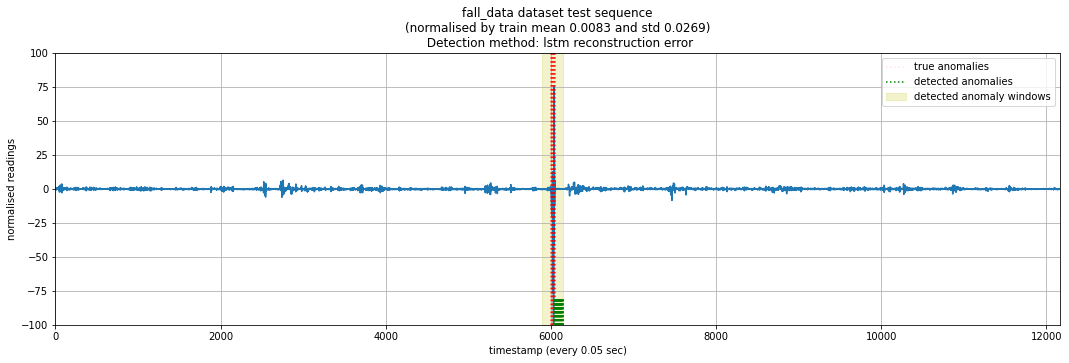

In [ ]:
plot_detected_anomalies(idx_detection, 
                        interval=config['l_win']*config['l_seq']/2, 
                        dataset=dataset, 
                        result=test_result, 
                        detection_method='lstm reconstruction error',
                        y_scale=100,
                        y_lim=100)